In [2]:
import nltk
import openpyxl
import pymorphy3
import json
import numpy as np
import pandas as pd
import datetime
import sklearn

# Обрабока котировок


In [3]:
def getDateOnly(date):
  return datetime.date(date.year, date.month, date.day)
def getDateOnlyFromString(date_string):
  return getDateOnly(datetime.datetime.strptime(str(date_string), '%Y-%m-%d').date())
def getDateDiffs(dates):
  dates.values.tolist()
  result = []
  for i in range(1, len(dates)):
    result.append((getDateOnly(dates[i]) - getDateOnly(dates[i-1])).days)
  df = pd.DataFrame(result, columns=['DATE_DIFF'])
  return df.groupby(['DATE_DIFF'])['DATE_DIFF'].count()

загрузка и подгонка длины датасетов по датам

In [4]:
def getDatasetsAndTrim(news_path, stocks_path, stocks_FULL_path):
  news = pd.read_csv(news_path)
  stocks = pd.read_csv(stocks_path) 
  stocks_full = pd.read_csv(stocks_FULL_path) 
  

  news_start_date = getDateOnlyFromString(news.iloc[0]['date'])
  stocks_start_date = getDateOnlyFromString(stocks.iloc[0]['DATE'])

  news_end_date = getDateOnlyFromString(news.iloc[-1]['date'])
  stocks_end_date = getDateOnlyFromString(stocks.iloc[-1]['DATE'])

  start_delta = (stocks_start_date - news_start_date).days
  end_delta = (stocks_end_date - news_end_date).days

  # удаление лишних строк в начале
  if (start_delta > 0):
    news = pd.DataFrame(news.iloc[start_delta:]).reset_index(drop=True)
  elif (start_delta < 0): 
    stocks = pd.DataFrame(stocks.iloc[-start_delta:]).reset_index(drop=True)
    stocks_full = pd.DataFrame(stocks_full.iloc[-start_delta:]).reset_index(drop=True)

  # удаление лишних строк в конце
  if (end_delta > 0):
    stocks = pd.DataFrame(stocks.iloc[:-end_delta]).reset_index(drop=True)
    stocks_full = pd.DataFrame(stocks_full.iloc[:-end_delta]).reset_index(drop=True)
  elif (end_delta < 0): 
    news = pd.DataFrame(news.iloc[:end_delta]).reset_index(drop=True)

  stocks_full = stocks_full.drop(['TICKER'], axis=1).reset_index(drop=True)

  #sber_Y['Y'] = sber_Y['Y'].apply(lambda x: x*100)
  stocks['Y'] = stocks['Y'].apply(lambda x: x>0)
  return news, stocks, stocks_full

In [413]:
news, stocks_Y, stocks_FULL = getDatasetsAndTrim('news_by_days_14.csv', 'market_data/gazprom_Y.csv', 'market_data/sber_FULL.csv')

In [414]:
news

,date,news_body
0,2006-01-24,состоявшести декабрь внеочередной общий собран...
1,2006-01-25,декабрь комстарый объединить телесистема объяв...
2,2006-01-26,состояться заседание совет директор газпром пл...
3,2006-01-27,компания strom telecom производитель телекомму...
4,2006-01-28,уважаемый господин коллектив весь душа поздрав...
...,...,...
6278,2023-04-03,мара риа новость прайма нарастить экспорт това...
6279,2023-04-04,четверг март мск фьючерс американский индекс s...
6280,2023-04-05,азиатский площадка вторник утром расти корейск...
6281,2023-04-06,азиатский площадка среда утром расти корейский...


In [372]:
stocks_Y

,DATE,Y
0,2006-01-24,False
1,2006-01-25,True
2,2006-01-26,False
3,2006-01-27,True
4,2006-01-28,False
...,...,...
6278,2023-04-03,False
6279,2023-04-04,True
6280,2023-04-05,False
6281,2023-04-06,True


In [253]:
stocks_FULL

,DATE,OPEN,HIGH,MID,LOW,CLOSE,VOL
0,2000-04-03,1422.00,1422.00,1396.000,1370.00,1385.00,16938
1,2000-04-04,1390.00,1546.00,1460.500,1375.00,1521.00,84058
2,2000-04-05,1475.10,1510.00,1448.750,1387.50,1398.00,48853
3,2000-04-06,1410.00,1462.99,1436.495,1410.00,1425.01,23364
4,2000-04-07,1416.00,1430.00,1407.500,1385.00,1416.00,19315
...,...,...,...,...,...,...,...
8400,2023-04-03,218.45,219.44,217.120,214.80,216.09,54788980
8401,2023-04-04,216.20,217.29,215.545,213.80,214.83,45747250
8402,2023-04-05,214.69,216.30,213.850,211.40,216.15,46127960
8403,2023-04-06,216.30,217.38,215.725,214.07,214.25,38993420


# Методы

In [373]:

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [374]:
from sklearn.svm import SVR, LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

In [375]:
from sklearn.feature_extraction.text import TfidfVectorizer
def getXYTfidfSized(X, Y, left_skip, right_skip):
  tfidf = TfidfVectorizer(lowercase=False)
  tfidf_vectorized = tfidf.fit_transform(X['news_body'].values[left_skip:right_skip].astype('U'))
  print(tfidf_vectorized.shape)
  return train_test_split(tfidf_vectorized, Y['Y'][left_skip:right_skip].to_numpy(), 
                                            test_size=0.2, 
                                            random_state=777)

In [401]:
left_skip = 4000  #4000
right_skip = 5000 #-800

In [415]:
X_train, X_test, y_train, y_test = getXYTfidfSized(news, stocks_Y, left_skip, right_skip)

(1000, 41403)


In [188]:
pipeline = Pipeline([
    ('estimator', SVC()),
])
classifiers = [
    KNeighborsClassifier(2),
    SVC(),
    #GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]
def createEstimators(classifiers):
  parameters = []
  for cls in classifiers:
    parameters.append({'estimator':[cls]})
  return parameters
parameters = createEstimators(classifiers)
parameters

[{'estimator': [KNeighborsClassifier(n_neighbors=2)]},
 {'estimator': [SVC()]},
 {'estimator': [DecisionTreeClassifier()]},
 {'estimator': [RandomForestClassifier()]},
 {'estimator': [MLPClassifier()]},
 {'estimator': [AdaBoostClassifier()]},
 {'estimator': [GaussianNB()]},
 {'estimator': [QuadraticDiscriminantAnalysis()]}]

In [36]:
gs = GridSearchCV(pipeline, createEstimators(classifiers))
gs

GridSearchCV(estimator=Pipeline(steps=[('estimator', SVC())]),
             param_grid=[{'estimator': [KNeighborsClassifier(n_neighbors=2)]},
                         {'estimator': [SVC()]},
                         {'estimator': [GaussianProcessClassifier()]},
                         {'estimator': [DecisionTreeClassifier()]},
                         {'estimator': [RandomForestClassifier()]},
                         {'estimator': [MLPClassifier()]},
                         {'estimator': [AdaBoostClassifier()]},
                         {'estimator': [GaussianNB()]},
                         {'estimator': [QuadraticDiscriminantAnalysis()]}])

In [416]:
X = X_train.toarray()

In [38]:
gs.fit(X, y_train)

D:\work\stocks-prediction\finam_parse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\work\stocks-prediction\finam_parse\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\work\stocks-prediction\finam_parse\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\work\stocks-prediction\finam_parse\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\work\stocks-prediction\finam_parse\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are 

GridSearchCV(estimator=Pipeline(steps=[('estimator', SVC())]),
             param_grid=[{'estimator': [KNeighborsClassifier(n_neighbors=2)]},
                         {'estimator': [SVC()]},
                         {'estimator': [GaussianProcessClassifier()]},
                         {'estimator': [DecisionTreeClassifier()]},
                         {'estimator': [RandomForestClassifier()]},
                         {'estimator': [MLPClassifier()]},
                         {'estimator': [AdaBoostClassifier()]},
                         {'estimator': [GaussianNB()]},
                         {'estimator': [QuadraticDiscriminantAnalysis()]}])

In [41]:
print(gs.best_params_)

{'estimator': RandomForestClassifier()}


In [42]:
gs.cv_results_

{'mean_fit_time': array([7.40002155e-02, 1.93092913e+01, 6.90128875e+00, 2.45911045e+00,
        1.50030627e+00, 1.29544100e+02, 2.58653302e+01, 3.29400301e-01,
        2.50756936e+00]),
 'std_fit_time': array([1.67308480e-03, 2.31643595e-01, 9.69045919e-02, 6.10551942e-01,
        2.80135073e-02, 1.22610887e+01, 2.61153384e-01, 3.57190373e-02,
        2.04707621e-02]),
 'mean_score_time': array([0.15239997, 7.25979466, 1.67324886, 0.0104002 , 0.01619997,
        0.03500018, 0.52410278, 0.0912004 , 0.13442283]),
 'std_score_time': array([0.11087933, 0.21071154, 0.08509899, 0.00080006, 0.00039988,
        0.00460451, 0.01617917, 0.01330295, 0.00391089]),
 'param_estimator': masked_array(data=[KNeighborsClassifier(n_neighbors=2), SVC(),
                    GaussianProcessClassifier(), DecisionTreeClassifier(),
                    RandomForestClassifier(), MLPClassifier(),
                    AdaBoostClassifier(), GaussianNB(),
                    QuadraticDiscriminantAnalysis()],
       

In [43]:
n = len(gs.cv_results_['mean_test_score']) 
for i in range(n):
  print(f"{gs.cv_results_['param_estimator'][i]} — {gs.cv_results_['mean_test_score'][i]}")

KNeighborsClassifier(n_neighbors=2) — 0.6775
SVC() — 0.6925000000000001
GaussianProcessClassifier() — 0.68125
DecisionTreeClassifier() — 0.6625
RandomForestClassifier() — 0.72125
MLPClassifier() — 0.70875
AdaBoostClassifier() — 0.6875
GaussianNB() — 0.70375
QuadraticDiscriminantAnalysis() — 0.6775


## Top 3 esitmator tuning


In [14]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [271]:
from sklearn.metrics import f1_score, precision_score,recall_score, precision_recall_curve, accuracy_score
def printScores(y_test, y_pred):
  f1 = f1_score(y_test, y_pred)
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  print(f"f1-score:  {f1}")
  print(f"accuracy:  {acc}")
  print(f"precision: {prec}")
  print(f"recall:    {rec}")
  return [f1,acc,prec,rec]

def convertPredictionToBool(y_pred):
  return np.array([i>0.5 for i in y_pred.flatten()])

In [137]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
def getConfusion(y_pred, y_test):
  printScores(y_pred, y_test)
  print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
  disp.plot()

### Random Forest

In [417]:
clf = RandomForestClassifier(random_state=777)

In [418]:
clf.fit(X, y_train)

RandomForestClassifier(random_state=777)

In [419]:
y_pred = clf.predict(X_test)

In [420]:
printScores(y_pred, y_test)

f1-score:  0.7156862745098039
accuracy:  0.71
precision: 0.6952380952380952
recall:    0.7373737373737373


(0.7156862745098039, 0.71, 0.6952380952380952, 0.7373737373737373)

f1-score:  0.7156862745098039
accuracy:  0.71
precision: 0.6952380952380952
recall:    0.7373737373737373
              precision    recall  f1-score   support

       False       0.68      0.73      0.70        95
        True       0.74      0.70      0.72       105

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.71      0.71      0.71       200



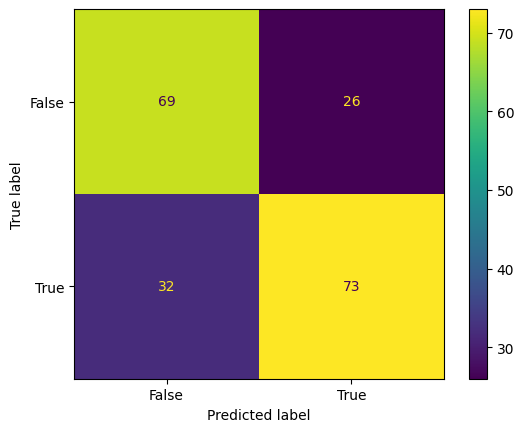

In [421]:
getConfusion(y_pred, y_test)

In [178]:
params = {
    'random_state':[777],
    'n_jobs': [-1],
    'n_estimators': [160],
    'max_features': ['log2'],
    'max_leaf_nodes': [10]
}
gridSearch = GridSearchCV(RandomForestClassifier(),
                           param_grid=params, cv=3)

In [179]:
gridSearch.fit(X, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['log2'], 'max_leaf_nodes': [10],
                         'n_estimators': [160], 'n_jobs': [-1],
                         'random_state': [777]})

In [180]:
print(gridSearch.best_estimator_)

RandomForestClassifier(max_features='log2', max_leaf_nodes=10, n_estimators=160,
                       n_jobs=-1, random_state=777)


In [181]:
print(gridSearch.best_score_)

0.6800287234941286


f1-score:  0.7373271889400921
accuracy:  0.715
precision: 0.7547169811320755
recall:    0.7207207207207207
              precision    recall  f1-score   support

       False       0.71      0.67      0.69        94
        True       0.72      0.75      0.74       106

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.71      0.71      0.71       200



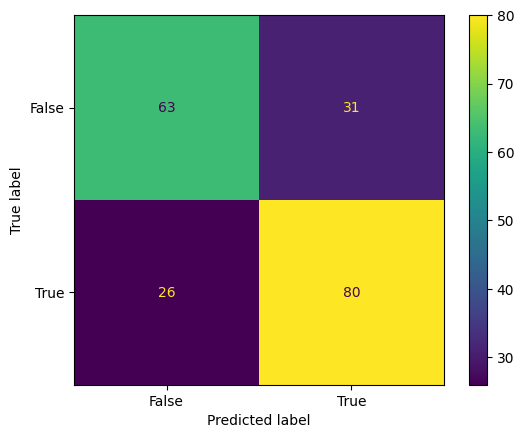

In [182]:
getConfusion(gridSearch.predict(X_test), y_test)

### Дополнительные данные


In [285]:
def getMetricsOverWholeDataset(size, delta_move):

  total_data = len(news)
  columns=['date','f1', 'accuracy', 'precision', 'recall']
  metrics = pd.DataFrame(columns=columns)
  for start in range(0, total_data - size, delta_move): 
    left_skip = start
    right_skip = start + size
    X_train, X_test, y_train, y_test = getXYTfidfSized(news, stocks_Y, left_skip, right_skip)
    clf = RandomForestClassifier(random_state=777)
    clf.fit(X_train.toarray(), y_train)
    y_pred = clf.predict(X_test)
    metrics = pd.concat([metrics, pd.DataFrame([(news['date'].iloc[start],) + printScores(y_pred, y_test)], columns=columns)])
  return metrics.reset_index(drop=True)

In [ ]:
metrics = getMetricsOverWholeDataset(1000, 500)

In [281]:
metrics.reset_index(drop=True, inplace=True)
metrics

,date,f1,accuracy,precision,recall
0,2006-01-24,0.794979,0.755,0.818966,0.772358
1,2007-06-08,0.721030,0.675,0.750000,0.694215
2,2008-10-20,0.825000,0.790,0.876106,0.779528
3,2010-03-04,0.716814,0.680,0.723214,0.710526
4,2011-07-17,0.777778,0.760,0.800000,0.756757
5,2012-11-28,0.703518,0.705,0.721649,0.686275
6,2014-04-12,0.735294,0.730,0.707547,0.765306
7,2015-08-25,0.747573,0.740,0.747573,0.747573
8,2017-01-06,0.736364,0.710,0.771429,0.704348
9,2018-05-21,0.803653,0.785,0.807339,0.800000


In [ ]:
all_metrics = []
size_delta = 100
for size in range(size_delta, 2000, size_delta):
  all_metrics.append(getMetricsOverWholeDataset(size, int(size/2)))

In [289]:
len(all_metrics)

19

In [303]:
print(len(all_metrics[0]))
print(len(all_metrics[-1]))

124
5


In [ ]:
row = all_metrics[15][['f1', 'accuracy',	'precision', 'recall']].mean(axis=0).tolist()
row.insert(0, 100)
row

In [368]:
columns = ['period', 'f1', 'accuracy',	'precision', 'recall']
size_delta = 100
i = 0
average_metrics = pd.DataFrame(columns=columns) 
for size in range(size_delta, 2000, size_delta):
  averages = np.array(all_metrics[i][['f1', 'accuracy',	'precision', 'recall']].std(axis=0).tolist()) # mean or std
  row = np.insert(averages, 0, size)
  average_metrics = pd.concat([average_metrics, 
                              pd.DataFrame([row],columns=columns)])
  i+=1
average_metrics.reset_index(drop=True, inplace=True)

In [369]:
average_metrics

,period,f1,accuracy,precision,recall
0,100.0,0.157186,0.115425,0.192289,0.166728
1,200.0,0.078090,0.067062,0.119465,0.091026
2,300.0,0.074258,0.062496,0.107058,0.080314
3,400.0,0.055090,0.053547,0.080086,0.075550
4,500.0,0.045914,0.038861,0.080950,0.049904
5,600.0,0.030826,0.032557,0.061077,0.044695
6,700.0,0.034897,0.035174,0.067758,0.034248
7,800.0,0.043266,0.035222,0.054550,0.054366
8,900.0,0.040118,0.038708,0.067748,0.041596
9,1000.0,0.039842,0.038976,0.050324,0.039135


### Multilayer Perceptron

In [76]:
clf = MLPClassifier()

In [68]:
clf.fit(X, y_train)

MLPClassifier()

In [69]:
y_pred = clf.predict(X_test)

In [70]:
printScores(y_pred, y_test)

f1-score:  0.7586206896551725
accuracy:  0.755
precision: 0.7264150943396226
recall:    0.7938144329896907


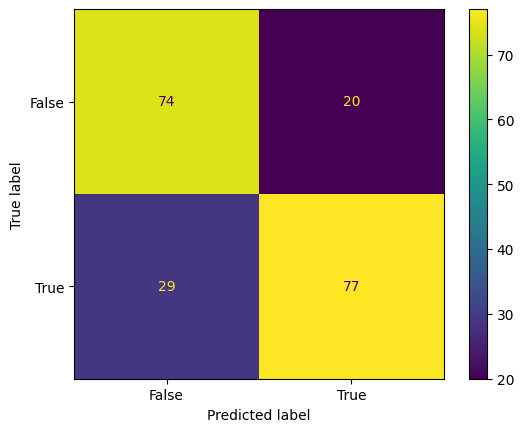

In [71]:
getConfusion(y_pred, y_test)

### Gaussian Naive Bayes

In [72]:
clf = GaussianNB()

In [75]:
clf.fit(X, y_train)

GaussianNB()

In [77]:
y_pred = clf.predict(X_test.toarray())

In [78]:
printScores(y_pred, y_test)

f1-score:  0.7263681592039801
accuracy:  0.725
precision: 0.6886792452830188
recall:    0.7684210526315789


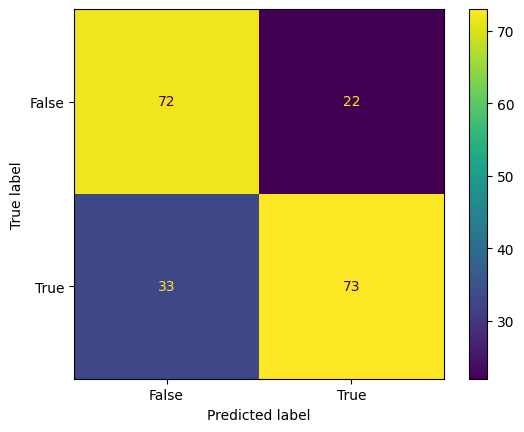

In [79]:
getConfusion(y_pred, y_test)

In [192]:
classifiers

[KNeighborsClassifier(n_neighbors=2),
 SVC(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 MLPClassifier(),
 AdaBoostClassifier(),
 GaussianNB(),
 QuadraticDiscriminantAnalysis()]

f1-score:  0.6480446927374302
accuracy:  0.685
precision: 0.5471698113207547
recall:    0.7945205479452054
              precision    recall  f1-score   support

       False       0.62      0.84      0.71        94
        True       0.79      0.55      0.65       106

    accuracy                           0.69       200
   macro avg       0.71      0.69      0.68       200
weighted avg       0.71      0.69      0.68       200

f1-score:  0.7162790697674418
accuracy:  0.695
precision: 0.7264150943396226
recall:    0.7064220183486238
              precision    recall  f1-score   support

       False       0.68      0.66      0.67        94
        True       0.71      0.73      0.72       106

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.69      0.69      0.69       200

f1-score:  0.7751196172248804
accuracy:  0.765
precision: 0.7641509433962265
recall:    0.7864077669902912
              precision  

D:\work\stocks-prediction\finam_parse\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


f1-score:  0.7329842931937173
accuracy:  0.745
precision: 0.660377358490566
recall:    0.8235294117647058
              precision    recall  f1-score   support

       False       0.69      0.84      0.76        94
        True       0.82      0.66      0.73       106

    accuracy                           0.74       200
   macro avg       0.76      0.75      0.74       200
weighted avg       0.76      0.74      0.74       200



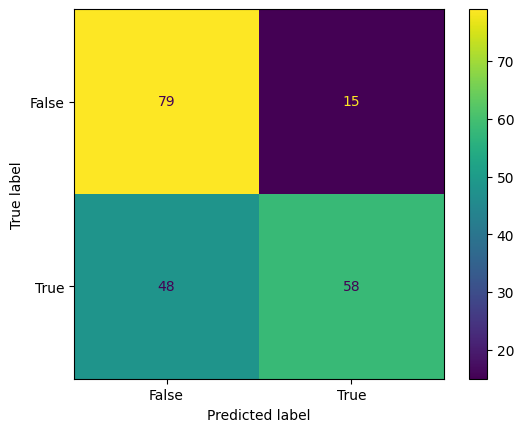

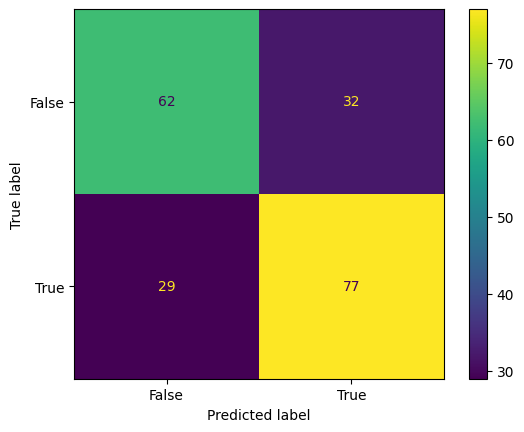

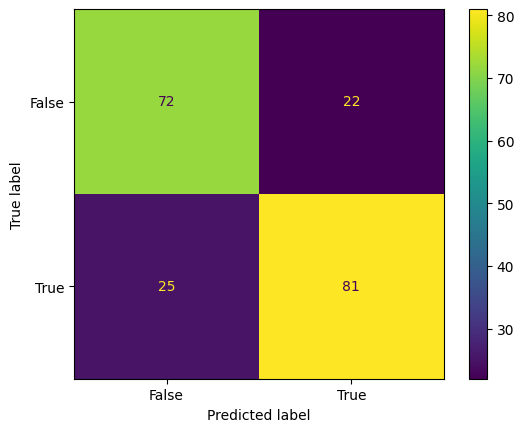

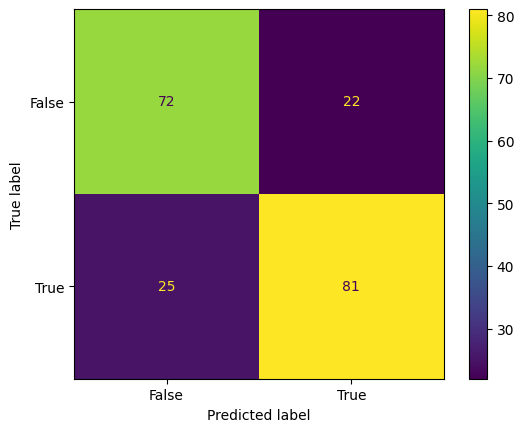

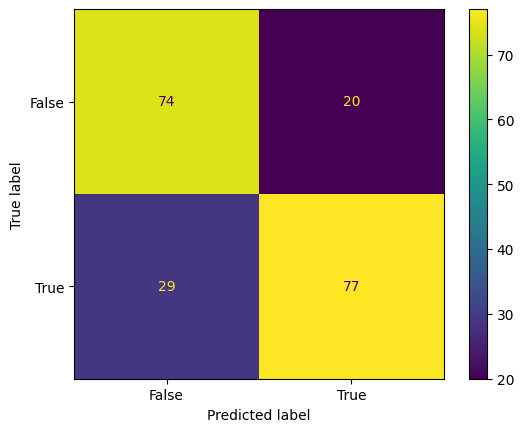

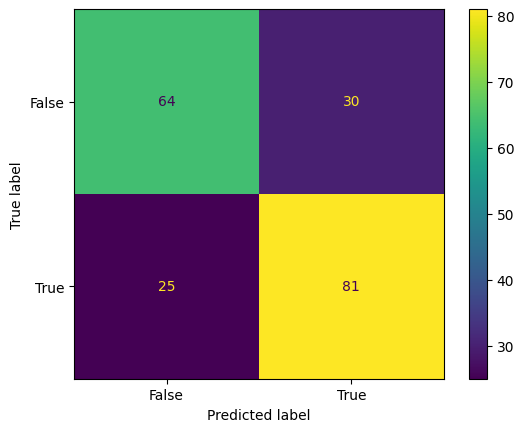

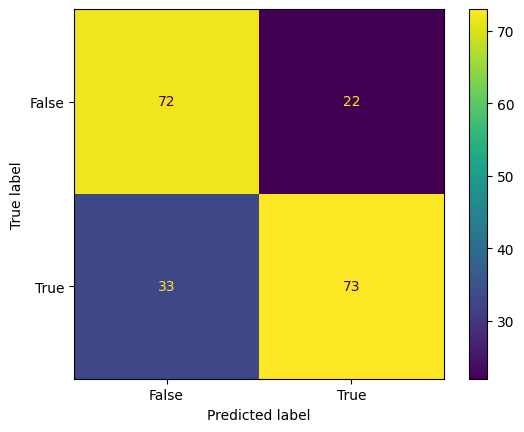

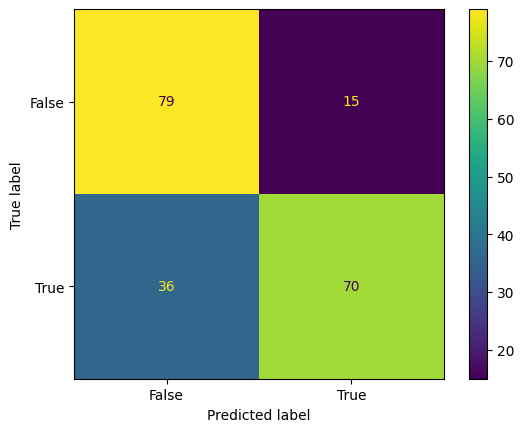

In [191]:
for cls in classifiers:
  cls.fit(X,y_train)
  getConfusion(cls.predict(X_test.toarray()), y_test)